In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
import torch

# 读取数据

In [2]:
data = untar_data(URLs.MNIST)

In [3]:
data.ls()

[PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/testing'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training')]

In [4]:
(data / 'training').ls()

[PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/1')]

## 假设我们对生成数字5很感兴趣

In [5]:
focus_num = '5'

In [6]:
path = data/'training'/focus_num

In [7]:
focus_imgs = list(path.glob('*.png'))

In [8]:
focus_imgs[:3]

[PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/5/19858.png'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/5/14183.png'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/5/13532.png')]

In [9]:
noise_dim = 100
bs = 128
img_size = 64
# 确保图片大小是2的幂次
data = GANItemList.from_folder(path, noise_sz=noise_dim) \
               .split_none()\
               .label_from_func(noop) \
               .transform(size = img_size, tfm_y=True) \
               .databunch(bs=bs)

### 看出来，我们的数据是 通道为3

In [10]:
data.train_ds[0]

(NoisyItem , Image (3, 64, 64))

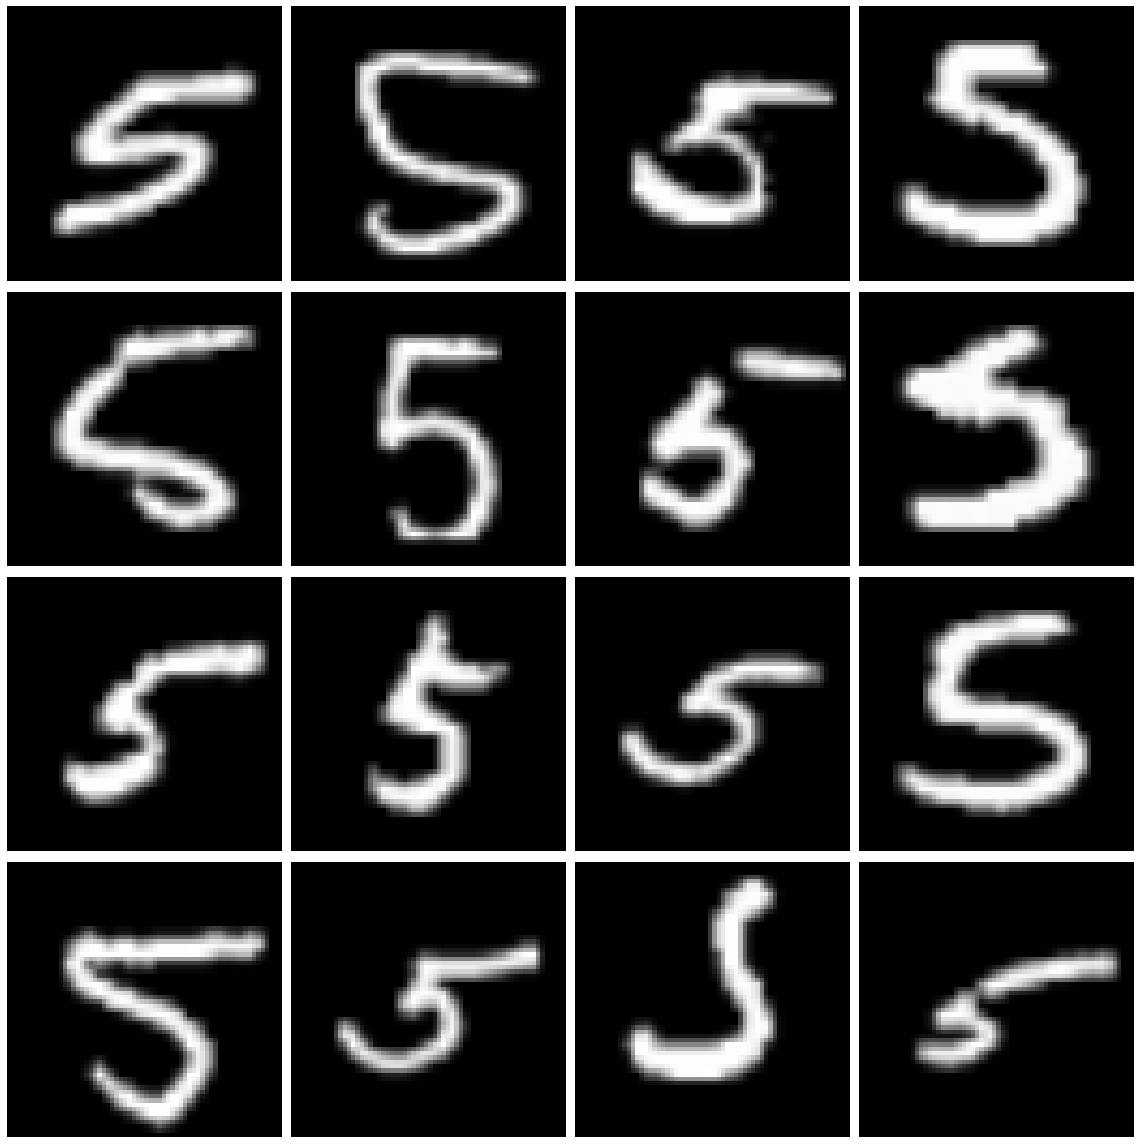

In [11]:
data.show_batch(rows=4)

In [12]:
generator = basic_generator(in_size=img_size, n_channels=3, noise_sz=noise_dim)
critic    = basic_critic   (in_size=img_size, n_channels=3)

In [13]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.244244,#na#,0.125283,-0.319079,00:05
1,-0.703867,#na#,0.383864,-0.920417,00:08
2,-0.965230,#na#,0.525798,-1.268138,00:09
3,-1.064652,#na#,0.596153,-1.411672,00:10
4,-1.106920,#na#,0.637472,-1.478384,00:11
5,-1.125943,#na#,0.664586,-1.511350,00:11
6,-1.135058,#na#,0.683500,-1.528326,00:12
7,-1.138786,#na#,0.696488,-1.535982,00:13
8,-1.140515,#na#,0.706406,-1.539953,00:16
9,-1.141368,#na#,0.714020,-1.541954,00:17


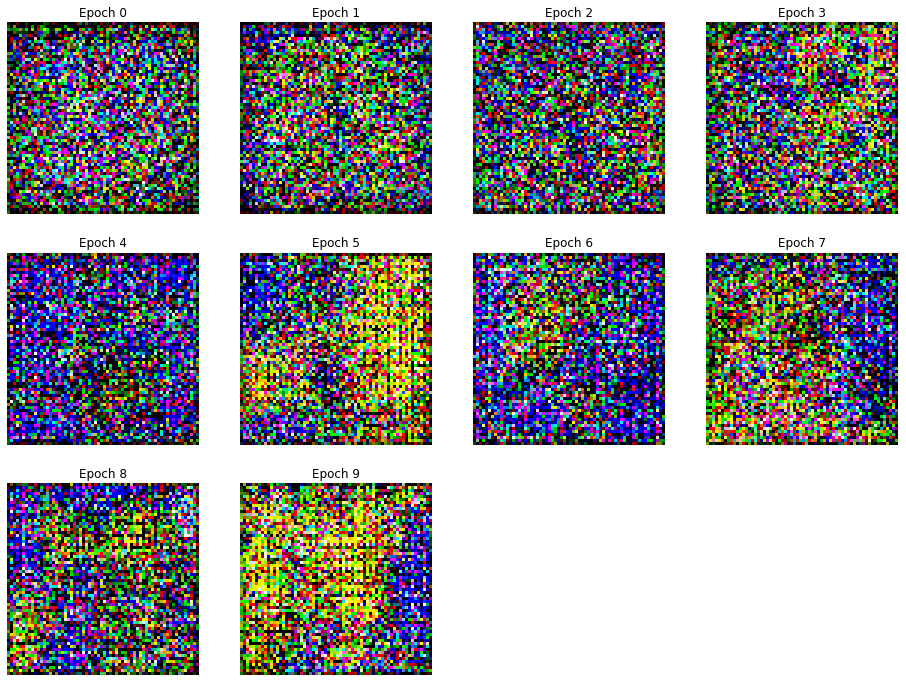

In [14]:
learn.fit_one_cycle(10, max_lr=1e-3)

# WGAN的生成效果如下

In [15]:
learn.gan_trainer.switch(gen_mode=True)

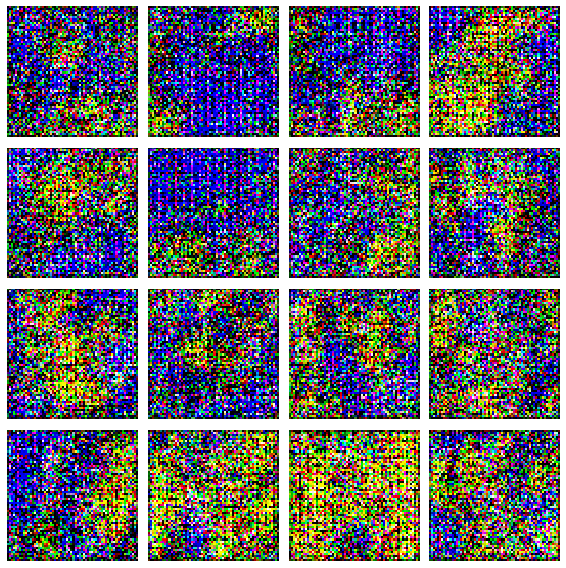

In [16]:
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,8))

分析一下就知道，我们的模型生成差的原因是，瞎子给瞎子指路。。。

In [17]:
learn.predict(data.train_ds[0][0])

(Image (3, 64, 64),
 tensor([[[-0.1762,  0.1800, -0.5446,  ...,  0.2886, -0.3354,  0.0511],
          [ 0.3470, -0.3563,  0.7738,  ...,  0.6457, -0.9096, -0.4911],
          [-0.0590,  0.1416,  0.8639,  ..., -0.0345, -0.9129, -0.3728],
          ...,
          [-0.5855, -0.7470, -0.3825,  ...,  0.6817,  0.4990,  0.1570],
          [-0.8130, -0.9713,  0.1008,  ...,  0.0833, -0.1111,  0.3077],
          [ 0.1793, -0.6631, -0.6150,  ...,  0.3225,  0.2996, -0.4723]],
 
         [[ 0.2139, -0.2905,  0.0546,  ..., -0.5926,  0.5745, -0.1845],
          [ 0.7109, -0.1997,  0.7948,  ..., -0.8456,  0.4655, -0.4938],
          [ 0.5570, -0.2747,  0.4629,  ..., -0.6570, -0.9880, -0.1387],
          ...,
          [-0.4041, -0.6756, -0.9225,  ...,  0.9236,  0.9968, -0.0390],
          [ 0.3417, -0.9945,  0.9494,  ..., -0.9267,  0.0838,  0.5348],
          [ 0.2195, -0.0701,  0.2531,  ..., -0.4556,  0.1020, -0.3392]],
 
         [[-0.3671, -0.0316, -0.4228,  ..., -0.0123, -0.1190, -0.1913],
        

# 如何提升效果呢？

试一试不瞎子指路，效果如何?  
即使用预训练生成对抗网络来检测实验结果

## 准备数据

### 生成器数据

### 定义一些需要的类

In [18]:
class MyImageList(ImageList):
    def get(self, i):
        res = self.items[i]
        self.sizes[i] = res.size
        return res

def f(x):
    v = x.label
    del x.label #消除标签值
    return v
class MyImageDataBunch(ImageDataBunch):
    @classmethod
    def from_lists(cls, path, imgs, **kwargs):
        
        src = (MyImageList(imgs, path = path).split_by_rand_pct(0.3, 0). \
               label_from_func(f))
        return cls.create_from_ll(src, **kwargs)
    @classmethod
    def from_pair(cls,path, imgs, **kwargs):
        src = (MyImageList(imgs, path=path).split_by_rand_pct(0.3, 0). \
                                label_from_func(f))
        return cls.create_from_ll(src, **kwargs)

In [19]:
gene_data = [open_image(w) for w in focus_imgs]
gene_data = [w.apply_tfms([], size = img_size) for w in gene_data] # 改变图像尺寸 3*28*28 -> 3*64*64
noise_items = [Image(NoisyItem(noise_dim).data) for _ in range(len(gene_data))]
assert len(noise_items) == len(gene_data)
for t, v in zip(noise_items, gene_data):
    t.label = v

In [20]:
generate_databunch = MyImageDataBunch.from_pair(path, noise_items, bs = 16)

In [21]:
generate_databunch.train_ds[0]

(Image (100, 1, 1), Image (3, 64, 64))

## 生成器训练

In [22]:
def loss_f(a, b): # 将loss的输入编程float型，并且做一些检验
    a = a.view(-1).float()
    b = b.view(-1).float()
    assert a.shape == b.shape, f"{a.shape} {b.shape}"
    return F.l1_loss(a, b)
    
g_learner = Learner(generate_databunch, generator, loss_func=loss_f,)

In [23]:
g_learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.175870,0.139034,00:09
1,0.128250,0.123557,00:10
2,0.119742,0.119768,00:10
3,0.116582,0.118643,00:10
4,0.111831,0.120820,00:11
5,0.105156,0.122775,00:11
6,0.088402,0.125739,00:11
7,0.075309,0.127220,00:11
8,0.064122,0.127717,00:12
9,0.058413,0.128260,00:12


In [24]:
g_learner.data.single_ds

LabelList (1626 items)
x: MyImageList
Image (100, 1, 1),Image (100, 1, 1),Image (100, 1, 1),Image (100, 1, 1),Image (100, 1, 1)
y: ItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: /home/liangjiaxi/.fastai/data/mnist_png/training/5

In [25]:
a = g_learner.predict(Image(NoisyItem(noise_dim).data))

In [26]:
pred_imgs = [Image(w.clamp_(0,1)) for w in a]

In [27]:
g_learner.save('/tmp/g_learner')

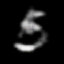

In [28]:
pred_imgs[0]

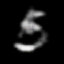

In [29]:
pred_imgs[1]

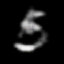

In [30]:
pred_imgs[2]

## 判别器数据

In [31]:
g_learner.load('/tmp/g_learner')

Learner(data=ImageDataBunch;

Train: LabelList (3795 items)
x: MyImageList
Image (100, 1, 1),Image (100, 1, 1),Image (100, 1, 1),Image (100, 1, 1),Image (100, 1, 1)
y: ItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: /home/liangjiaxi/.fastai/data/mnist_png/training/5;

Valid: LabelList (1626 items)
x: MyImageList
Image (100, 1, 1),Image (100, 1, 1),Image (100, 1, 1),Image (100, 1, 1),Image (100, 1, 1)
y: ItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: /home/liangjiaxi/.fastai/data/mnist_png/training/5;

Test: None, model=Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1):

In [32]:
true = [open_image(w).apply_tfms([],size = img_size) for w in focus_imgs]
for t in true:
    t.label = 1

In [33]:
fake = [Image(g_learner.predict(data.train_ds[i][0])[0].clamp_(0,1)).apply_tfms([],size = img_size) for i in range(len(true))]

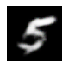

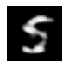

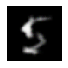

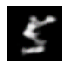

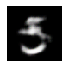

In [34]:
for i in range(5):
    (fake[i]).show(figsize = (1,1))

In [35]:
for t in fake:
    t.label = 0

critic_data = true + fake

assert all([isinstance(w, Image) for w in critic_data]) # make sure

In [36]:
critic_data[-2].shape

torch.Size([3, 64, 64])

In [37]:
critic_data[2].shape

torch.Size([3, 64, 64])

In [38]:
critic_data[-2].label

0

In [39]:
set([w.label for w in critic_data])

{0, 1}

In [40]:
critic_databunch = MyImageDataBunch.from_lists(path, critic_data, size = img_size) # make sure picture is the same size

## 判别器训练 

In [41]:
critic_databunch.train_ds[-5:]

LabelList (5 items)
x: MyImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: /home/liangjiaxi/.fastai/data/mnist_png/training/5

In [42]:
def wrapper(func):
    def f(a, b):
        a = a.float()
        b = b.long()
        assert b.max() <= 1 and b.min() >= 0, f'{b}'
        return func(a, b)
    return f
c_learner = Learner(critic_databunch, create_cnn_model(models.resnet18, 2), loss_func=wrapper(F.cross_entropy))

In [43]:
c_learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.051817,9.326221,00:13
1,0.022744,0.005303,00:11
2,0.062686,7.101125,00:11
3,0.010091,0.039876,00:11
4,0.007239,0.015636,00:11
5,0.006808,0.000100,00:12
6,0.004942,0.000310,00:12
7,0.002618,0.000049,00:13
8,0.000442,0.000009,00:13
9,0.000084,0.000009,00:14


In [44]:
c_learner.save('/tmp/c_learner')

In [45]:
c_learner = Learner(critic_databunch, create_cnn_model(models.resnet18, 2))
g_learner = Learner(generate_databunch, generator, loss_func=loss_f,)

In [46]:
g_learner = g_learner.load('/tmp/g_learner')
c_learner = c_learner.load('/tmp/c_learner')
c_learner.loss_func = wrapper(F.cross_entropy)

In [47]:
# 确保图片大小是2的幂次
data = GANItemList.from_folder(path, noise_sz=noise_dim) \
               .split_none()\
               .label_from_func(noop) \
               .transform(size = img_size, tfm_y=True) \
               .databunch(bs=18)

In [48]:
# gan_learner = GANLearner.wgan(data, g_learner.model, c_learner.model, )

In [49]:
class MyTrainer(GANTrainer):
    
    def on_epoch_end(self, pbar, epoch, last_metrics, **kwargs):
#         print('a')
        "Put the various losses in the recorder and show a sample image."
        if not hasattr(self, 'last_gen'): print('lalala')
        if not hasattr(self, 'last_gen') or not self.show_img: return
#         print('b')
        data = self.learn.data
        img = self.last_gen[0]
        norm = getattr(data,'norm',False)
        if norm and norm.keywords.get('do_y',False): img = data.denorm(img)
        img = data.train_ds.y.reconstruct(img)
        self.imgs.append(img)
        self.titles.append(f'Epoch {epoch}')
        pbar.show_imgs([Image(w.clamp_(0,1)) for w in self.imgs if isinstance(w, torch.Tensor)], self.titles)
        return add_metrics(last_metrics, [getattr(self.smoothenerG,'smooth',None),getattr(self.smoothenerC,'smooth',None)])

In [50]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
gan_learner = GANLearner.from_learners(g_learner, c_learner, weights_gen=(1.,50.), show_img=True, 
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=0)
# gan_learner.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [51]:
a = MyTrainer(gan_learner)
gan_learner.gan_trainer = a
gan_learner.callbacks.pop()
gan_learner.callbacks.append(a)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,1.486139,1.942754,4.605816,0.836514,00:26
1,1.594286,2.117865,4.973055,0.817990,00:25
2,1.639796,3.367666,5.474549,0.805587,00:25
3,1.818699,2.045421,6.048148,0.813076,00:25
4,1.696480,2.132246,6.150128,0.807123,00:25
5,1.792322,2.167204,6.202445,0.803707,00:24
6,1.676491,3.101003,6.125764,0.812674,00:25
7,1.691637,3.562353,6.170922,0.778630,00:24
8,1.646672,2.218185,6.104834,0.777674,00:25
9,1.731254,1.766214,6.094892,0.775509,00:25


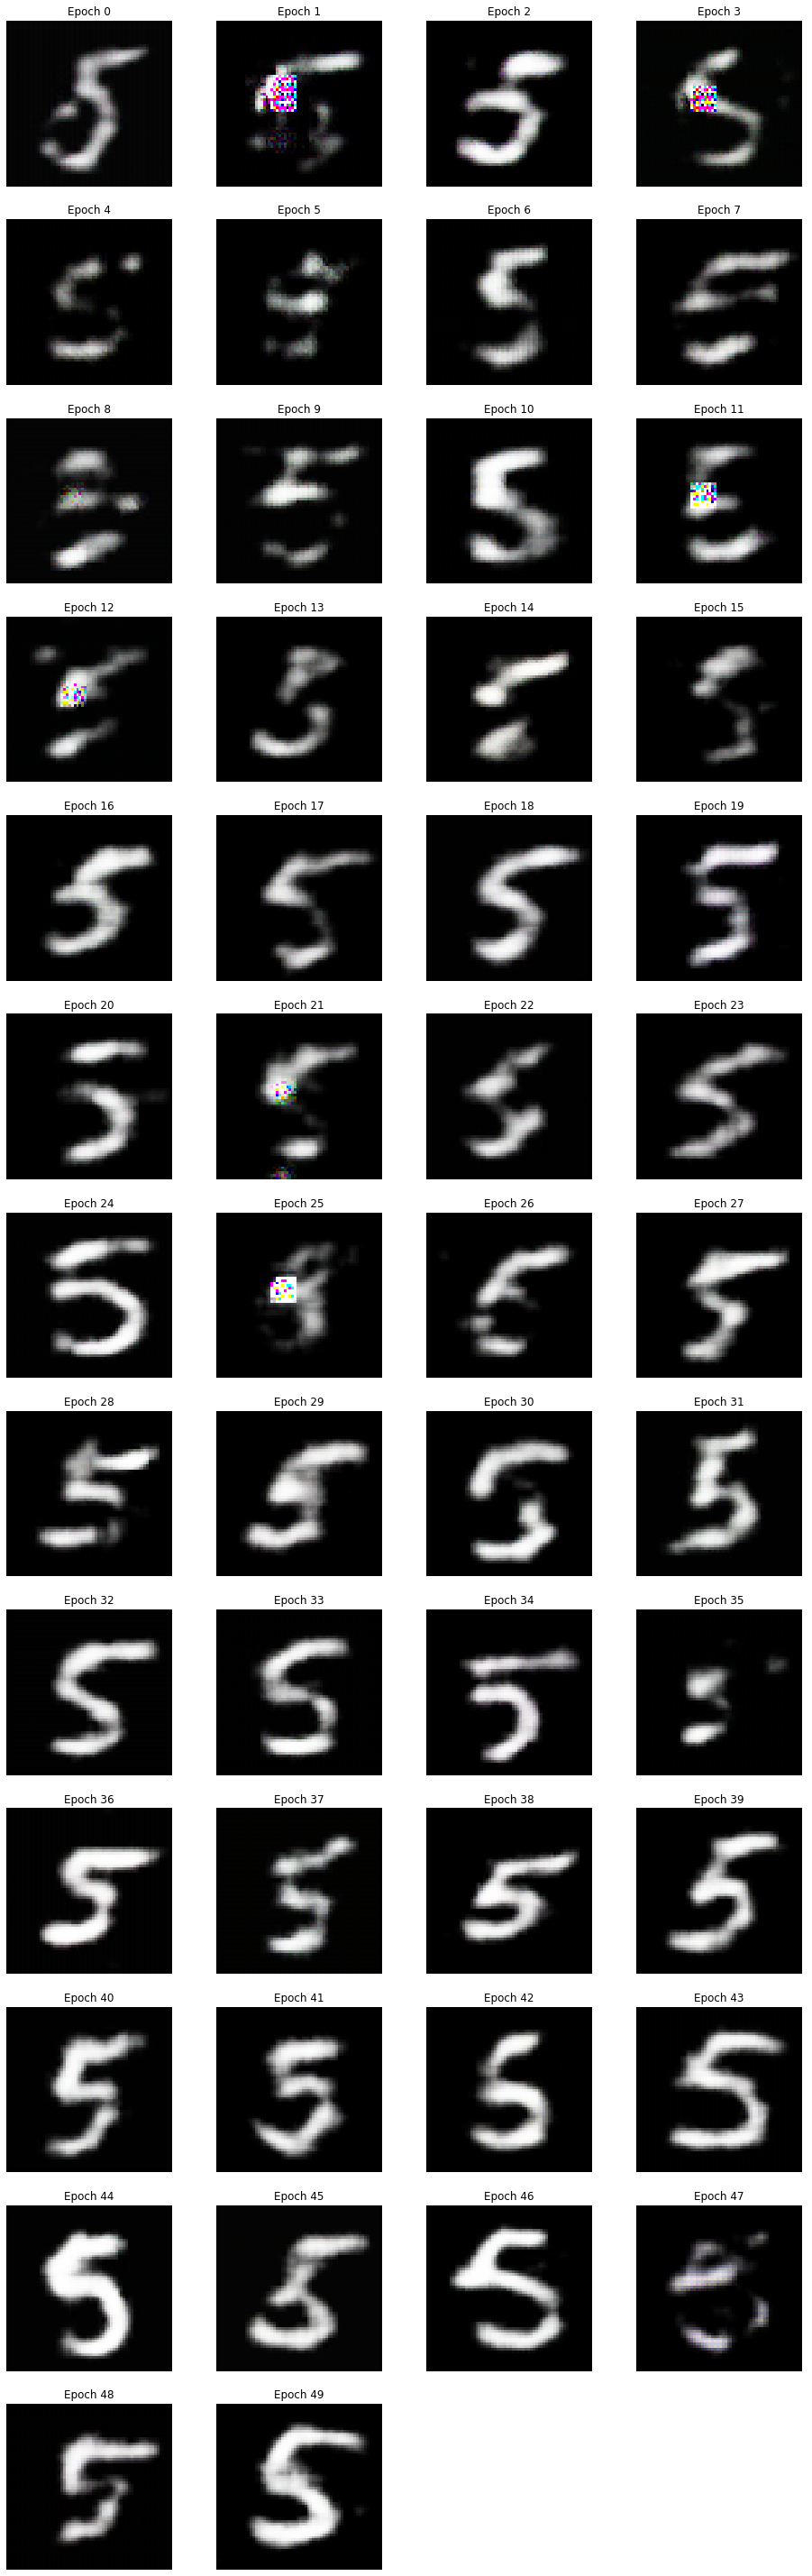

In [52]:
gan_learner.fit(50)

In [ ]:
gan_learner.save('gan_learner')